<img src='../../media/common/LogoWekeo_Copernicus_RGB_0.png' align='left' height='96px'></img>

<hr>

# Scaling up with `eo-learn`

*Authors: Adrian Di Paolo, Chung-Xiang Hong, Jonas Viehweger* 

`eo-learn` is a library which is especially written to prepare satellite data for machine learning workflows at large scale.

In this workflow we are scaling up the previous analysis to country level. This poses new challenges but also offers benefits in terms of the generalization of the model. The challenges will be the handling of all the data, which in this case is done with `eo-learn`.

To get the data in this notebook, Sentinel Hub Services are used. Those services are not free to use, however they offer a lot of benefits in terms of ease of use.
To test this notebook anyway you can start a [free trial](https://www.sentinel-hub.com/trial) at Sentinel Hub and use this account to run the notebook. 

In the future this notebook can also be run using [CDSE](https://dataspace.copernicus.eu/), which will offer very similar services to Sentinel Hub to its Users for free.

1. [Define the Area-of-Interest (AOI):](#define)

2. [Accessing Data](#preprocessing-data)

3. [Sampling Data](#model-training)

3. [Data Preparation](#model-training)
    
4. [Model Training](#model-evaluation)

3. [Inference & Validation](#model-training)

First, some necessary imports.

In [1]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import itertools

# Built-in modules
import os
from pathlib import Path
import json
from datetime import datetime, timedelta
import random

# Basics of Python data handling and visualization
import numpy as np

rng = np.random.default_rng(42)
import pandas as pd
import geopandas as gpd
import joblib

# Machine learning
import lightgbm as lgb
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from sklearn import metrics, preprocessing
from tqdm.auto import tqdm
from imblearn.under_sampling import RandomUnderSampler

from sentinelhub import DataCollection, BBoxSplitter, SHConfig

# Imports from eo-learn and sentinelhub-py
from eolearn.core import (
    EOExecutor,
    EOPatch,
    EOTask,
    EOWorkflow,
    FeatureType,
    LoadTask,
    OverwritePermission,
    SaveTask,
    linearly_connect_tasks,
)
from eolearn.geometry import ErosionTask, VectorToRasterTask
from eolearn.io import ExportToTiffTask, SentinelHubEvalscriptTask, VectorImportTask
from eolearn.ml_tools import FractionSamplingTask
import warnings
warnings.filterwarnings('ignore')


Here the client ID and secret from the sentinelhub account need to be defined. See [here](https://docs.sentinel-hub.com/api/latest/api/overview/authentication/) on how to do this. 

In [2]:
from credentials import CLIENT_ID, CLIENT_SECRET

config = SHConfig()

config.sh_base_url = 'https://creodias.sentinel-hub.com'
config.sh_client_secret = CLIENT_SECRET 
config.sh_client_id =  CLIENT_ID
hrvpp = DataCollection.define_byoc("67c73156-095d-4f53-8a09-9ddf3848fbb6")

In [3]:
# Folder where data for running the notebook is stored
DATA_FOLDER = Path("../../data/raw/ml-grassland-classification", "data")
# Locations for collected data and intermediate results
EOPATCH_FOLDER = Path("../../data/processing/ml-grassland-classification", "eopatches")
EOPATCH_SAMPLES_FOLDER = Path("../../data/processing/ml-grassland-classification", "eopatches_sampled")
RESULTS_FOLDER = Path("../../data/processing/ml-grassland-classification", "results")
for folder in (EOPATCH_FOLDER, EOPATCH_SAMPLES_FOLDER, RESULTS_FOLDER):
    folder.mkdir(exist_ok=True, parents=True)

##### 1. Define the Area-of-Interest (AOI):

We are defining all of Netherlands as the Area of Interest.

Dimension of the area is 280302 x 312610 m2


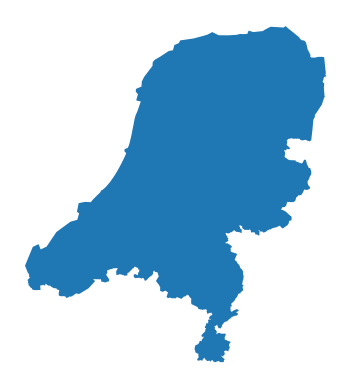

In [4]:
# Load geojson file
country = gpd.read_file(DATA_FOLDER / "NL_BORDER.geojson").to_crs(3035)
# Add 500m buffer to secure sufficient data near border
country = country.buffer(500)

# Get the country's shape in polygon format
country_shape = country.geometry.values[0]

# Plot country
country.plot()
plt.axis("off")

# Print size
country_width = country_shape.bounds[2] - country_shape.bounds[0]
country_height = country_shape.bounds[3] - country_shape.bounds[1]
print(f"Dimension of the area is {country_width:.0f} x {country_height:.0f} m2")

#### Preparation of EOPatches

EOPatches are the data structure which allows eo-learn to perform the data preparation at a large scale.
They hold all types of geospatial data for a specific bounding box. The workflow which will be defined is then applied to all EOPatches individually which makes operations at large scale possible.

In our case we are splitting up Netherlands into many small bounding boxes for which data is later being downloaded. 
To keep the whole workflow lighter for now we are only selecting 100 random bounding boxes.

In [5]:
# Create a splitter to obtain a list of bboxes with 5km sides
bbox_splitter = BBoxSplitter([country_shape], country.crs, split_size=5000)

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
idxs_x = [info["index_x"] for info in info_list]
idxs_y = [info["index_y"] for info in info_list]
idxs = list(range(0, len(idxs_x))) #[info["index"] for info in info_list]

bbox_gdf = gpd.GeoDataFrame({"index": idxs, "index_x": idxs_x, "index_y": idxs_y}, crs=country.crs, geometry=geometry)

number_of_patches = 20
# pick a number of patches
patchIDs = random.sample(range(len(bbox_list)), number_of_patches)

# Save to shapefile
shapefile_name = "grid_netherlands_500x500.gpkg"
bbox_gdf.to_file(os.path.join(RESULTS_FOLDER, shapefile_name), driver="GPKG")


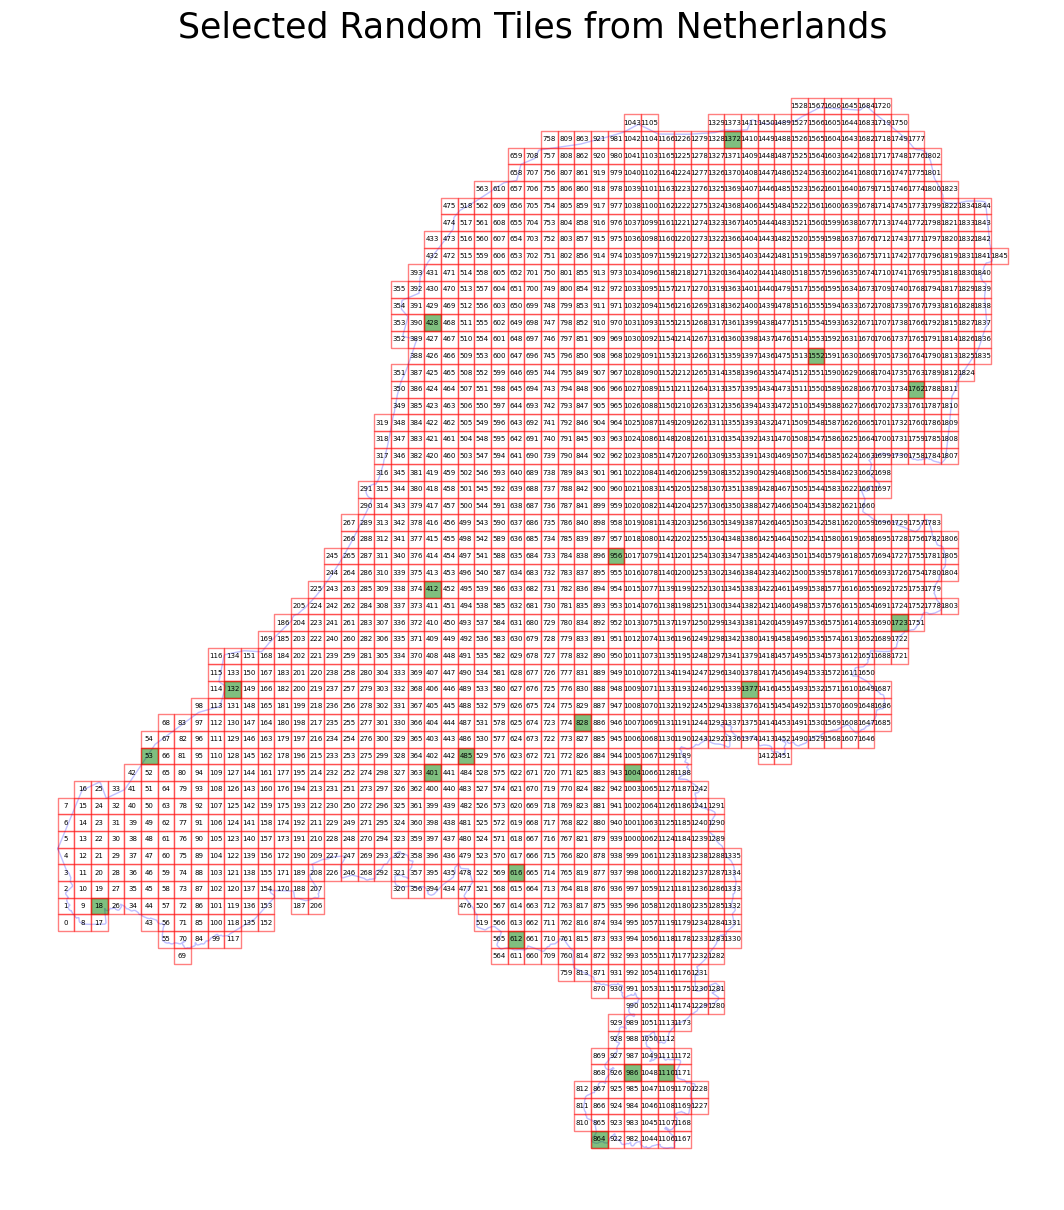

In [6]:
# Display bboxes over country
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title("Selected Random Tiles from Netherlands", fontsize=25)
country.plot(ax=ax, facecolor="w", edgecolor="b", alpha=0.5)
bbox_gdf.plot(ax=ax, facecolor="w", edgecolor="r", alpha=0.5)

for bbox in bbox_gdf.itertuples():
    geo = bbox.geometry
    ax.text(geo.centroid.x, geo.centroid.y, bbox.index, ha="center", va="center", fontsize=5)

# Mark bboxes of selected area
bbox_gdf[bbox_gdf.index.isin(patchIDs)].plot(ax=ax, facecolor="g", edgecolor="r", alpha=0.5)

plt.axis("off");

### Work Flows

#### Access Data

Here we define a workflow which gets all the data we will need into the EOPatches.

For this first we get the HRVPP data. This is our input data to the model. Then we also get cloud free true color Sentinel 2 data which we need later for some visualization.

Then the Ground Truth Data is imported with the `VectorImportTask`. The following tasks already do some data preparation for the ground truth data. The AddLabelTask adds an numeric label. The vectors are then transformed to rasters using this label as the value. Finally the dates in the input data get transformed from a format like YYDOY to a format which records the day since the first of the year.

The EOPatch with this data and the applied transformations is then saved for later use.

![Test](./images/access.svg)

In [7]:
evalscript ='''

///VERSION=3

function setup() {
  return {
    input: ["AMPL","EOSD","EOSV","LENGTH","LSLOPE","MAXD","MAXV","MINV","QFLAG","RSLOPE","SOSD","SOSV","SPROD","TPROD"],
    output: [{
      id: "BANDS",
      bands: 14,
      sampleType: "UINT16"}],
  }
}
//EvaluatePixel function
function evaluatePixel(sample) 
{
  return {BANDS: [sample.AMPL, sample.EOSD, sample.EOSV, sample.LENGTH, sample.LSLOPE, sample.MAXD, sample.MAXV, sample.MINV, sample.QFLAG, sample.RSLOPE, sample.SOSD, sample.SOSV, sample.SPROD, sample.TPROD]};
}
'''

In [8]:
true_color_evalscript='''
//VERSION=3
let minVal = 0.0;
let maxVal = 0.4;

let viz = new HighlightCompressVisualizer(minVal, maxVal);

function setup() {
   return {
    input: ["B04", "B03", "B02","dataMask"],
    output: [{
      id: "BANDS_TC",
      bands: 4,
      sampleType: "AUTO"}],
  };
}

function evaluatePixel(samples) {
    let val = [samples.B04, samples.B03, samples.B02,samples.dataMask];
    return viz.processList(val);
}
'''


In [9]:
add_true_color = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "BANDS_TC"),
    evalscript=true_color_evalscript,
    resolution=10,
    time_difference=timedelta(days=7),
    mosaicking_order='leastCC',
    data_collection=DataCollection.SENTINEL2_L2A,
    maxcc=0.8,
    max_threads=5,
    config=config
)

In [10]:
add_data = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "BANDS"),
    evalscript=evalscript,
    resolution=10,
    time_difference=None,
    data_collection=hrvpp,
    max_threads=5,
    config=config
)

# SAVING TO OUTPUT (if needed)
save = SaveTask(EOPATCH_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [11]:
class TransformDatesTask(EOTask):
    def __init__(self, features):
        self.features = features

    def clean_data(self, x_data):
        #features = np.concatenate([eopatch.data["FEATURES_SAMPLED"] for eopatch in x_data], axis=1)
        # Get shape
        
        arr = x_data[:, :, :, [1, 5, 10]]
        arr = np.nan_to_num(arr, nan=0)
        
        def yd_to_datetime(yd):
            return None if yd == 0 else datetime.strptime(str(yd), '%y%j')            
        def count_days(yd):
            if yd == -1 or yd is None:
                return 0
            else:
                return (yd - datetime(yd.year, 1, 1)).days
            
        dates = np.vectorize(yd_to_datetime)(arr)
        dates = np.where(dates is None, -1, dates) 
                    
        days = np.vectorize(count_days)(dates)
        days = np.where(days == None, 0, days)

        x_data[:, :, :, [1, 5, 10]] = days

        return x_data
    
    def execute(self, eopatch):
        x_data = eopatch.data[self.features]
        x_data = self.clean_data(x_data)
        eopatch.data[self.features] = x_data
        return eopatch
        

transformation_task = TransformDatesTask("BANDS")


In [12]:
vector_feature = FeatureType.VECTOR_TIMELESS, "GROUND_TRUTH"

vector_import_task = VectorImportTask(vector_feature, Path("../../data/processing/ml-grassland-classification", "data", "NL_2020_EC21.shp"))

class AddLabelTask(EOTask):
    """
    Adds a label column with the correct dtype to the vector file
    """

    def __init__(self, vector_feature):
        self.vector_feature = vector_feature

    def execute(self, eopatch):
        gpd_df = eopatch.vector_timeless[self.vector_feature]
        gpd_df["label"] = gpd_df.EC_hcat_c.astype(float)
        eopatch.vector_timeless[self.vector_feature] = gpd_df
        return eopatch

add_label_task = AddLabelTask("GROUND_TRUTH")

rasterization_task = VectorToRasterTask(
    vector_feature,
    (FeatureType.MASK_TIMELESS, "LABEL"),
    values_column="label",
    raster_shape=(FeatureType.DATA, "BANDS"),
    raster_dtype=np.uint32,
)

In [13]:
# Define the workflow
workflow_nodes = linearly_connect_tasks(
     add_data, add_true_color, vector_import_task, add_label_task, rasterization_task, transformation_task, save
)
workflow = EOWorkflow(workflow_nodes)

In [14]:
%%time

# Time interval for the SH request
time_interval = ["2016-01-05", "2021-01-05"]

# Define additional parameters of the workflow
input_node = workflow_nodes[0]
save_node = workflow_nodes[-1]
execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append(
        {
            input_node: {"bbox": bbox, "time_interval": time_interval},
            save_node: {"eopatch_folder": f"eopatch_{idx}"},
        }
    )

# Execute the workflow
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=4)

#executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 373 ms, sys: 97.2 ms, total: 471 ms
Wall time: 9min 59s


#### Sample Data

In this task data is sampled from the ground truth dataset. For this, first the EOPatches created in the previous steps are loaded from disk. Then an Erosion Task is carried out. This erosion task removes pixels on the edges of polygons. This is done because pixels on the edges of polygons are often ambiguous and may contain signals from different land use classes. Doing this erosion thus likely increases the quality and purity of the training data. Afterwards a predetermined fraction of all pixels in the EOPatch are sampled per class. In our case we are sampling a quarter of all pixels. These sampled pixels are then saved again.

![Sampling](images/sampling.svg)

In [15]:
# LOAD EXISTING EOPATCHES
load = LoadTask(EOPATCH_FOLDER)

# erode each class of the reference map
erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS, "LABEL", "LABEL_ERODED"), disk_radius=1)

# SPATIAL SAMPLING
# Uniformly sample pixels from patches

spatial_sampling = FractionSamplingTask(
    features_to_sample=[(FeatureType.DATA, "BANDS", "FEATURES_SAMPLED"), (FeatureType.MASK_TIMELESS, "LABEL_ERODED")],
    sampling_feature=(FeatureType.MASK_TIMELESS, "LABEL_ERODED"),
    fraction=0.25,  # a quarter of points
    exclude_values=[0],
)

save = SaveTask(EOPATCH_SAMPLES_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [16]:
workflow_nodes = linearly_connect_tasks(load, erosion, spatial_sampling, save)
workflow = EOWorkflow(workflow_nodes)

In [17]:
%%time

execution_args = []
for idx in range(len(patchIDs)):
    execution_args.append(
        {
            workflow_nodes[0]: {"eopatch_folder": f"eopatch_{idx}"},  # load
            workflow_nodes[-2]: {"seed": 42},  # sampling
            workflow_nodes[-1]: {"eopatch_folder": f"eopatch_{idx}"},  # save
        }
    )

executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5)

#executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 112 ms, sys: 79.9 ms, total: 192 ms
Wall time: 4.99 s


In [18]:
# Load sampled eopatches
sampled_eopatches = []

for i in range(len(patchIDs)):
    sample_path = EOPATCH_SAMPLES_FOLDER / f"eopatch_{i}"
    sampled_eopatches.append(EOPatch.load(sample_path, lazy_loading=True))

#### Data Preparation outside eo-learn

The sampled EOPatches are split up into a train and test set. The test set will be used for validation and the train set for training the model.

This is the part where we have to move away from eo-learn and convert the data into a format usable by the big machine learning libraries. This means that we now have access to the complete training dataset in one, which allows us to do some more pre-processing.

The first pre-processing step is cleaning the dataset of null values. These values can not be used in the algorithm and are thus discarded. The second step is the normalization of values using a minMax scaler. This gives all input values the same range, from 0-1. This is done so that values which naturally have a bigger numeric range, do not overproportionally impact the model. Finally the data is randomly undersampled to give both classes, Grassland and No Grassland the same amount of samples. This is called balancing the dataset.

![Final preparation](images/final_prep.svg)

In [19]:
 # Definition of the train and test patch IDs, take 80 % for train
test_ID = rng.choice(len(patchIDs), replace=False, size=int(len(patchIDs)*0.20))
test_eopatches = [sampled_eopatches[i] for i in test_ID]
train_ID = [i for i in range(len(patchIDs)) if i not in test_ID]
train_eopatches = [sampled_eopatches[i] for i in train_ID]


# Set the features and the labels for train and test sets
features_train = np.concatenate([np.expand_dims(eopatch.data["FEATURES_SAMPLED"][-2], axis=0) for eopatch in train_eopatches], axis=1)
labels_train = np.concatenate([eopatch.mask_timeless["LABEL_ERODED"] for eopatch in train_eopatches], axis=0)


features_test = np.concatenate([np.expand_dims(eopatch.data["FEATURES_SAMPLED"][-2], axis=0)  for eopatch in test_eopatches], axis=1)
labels_test = np.concatenate([eopatch.mask_timeless["LABEL_ERODED"] for eopatch in test_eopatches], axis=0)

# Get shape
t, w1, h, f = features_train.shape
t, w2, h, f = features_test.shape

# Reshape to n x m
features_train = np.moveaxis(features_train, 0, 2).reshape(w1 * h, t * f)
labels_train = labels_train.reshape(w1 * h)
features_test = np.moveaxis(features_test, 0, 2).reshape(w2 * h, t * f)
labels_test = labels_test.reshape(w2 * h)

In [20]:
def clean_null_values(x_data, y_data=None):
    """Transform the data to dataframe and cleans it"""
    x_df = pd.DataFrame(x_data, columns = ["AMPL","EOSD","EOSV","LENGTH","LSLOPE","MAXD","MAXV","MINV","QFLAG","RSLOPE","SOSD","SOSV","SPROD","TPROD"])
    if y_data is not None:
        y_df = pd.DataFrame(y_data, columns=['LABEL'])
        df = x_df.join(y_df)
    else:
        df = x_df
    df = df.dropna()
    df = df[~(df[['EOSD', 'SOSD', 'MAXD', 'LENGTH']] == 0).any(axis=1)]
    df = df[~(df[['SOSV', 'EOSV', 'MAXV', 'MINV', 'AMPL', 'LSLOPE', 'RSLOPE']] == 32768).any(axis=1)]
    df = df[~(df[['SPROD', 'TPROD']] == 65535).any(axis=1)]
    return df.drop(['LABEL'], axis=1), df['LABEL']


In [21]:
features_train, labels_train = clean_null_values(features_train, labels_train)
features_test, labels_test = clean_null_values(features_test, labels_test)

In [22]:
scaler = preprocessing.MinMaxScaler()
features_train = scaler.fit_transform(features_train)

In [23]:
to_classify = [
    3302000000  # Grassland
    ]
labels_train = np.where(np.isin(labels_train, to_classify), 1, 0)
labels_test = np.where(np.isin(labels_test, to_classify), 1, 0)

In [24]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(features_train, labels_train)

#### Model training

This step does the actual training. Here we use parameters which we identified in the previous notebook. The model is then saved. 

In [25]:
%%time

# Set up training classes
labels_unique = np.unique(y_resampled)
model = lgb.LGBMClassifier(learning_rate=0.1, max_depth=14, num_leaves=300, n_jobs=4, random_state=42)# Set up the model

# Train the model
model.fit(X_resampled, y_resampled)

# Save the model
joblib.dump(model, RESULTS_FOLDER / "model_reduced_classes.pkl")

CPU times: user 18.8 s, sys: 107 ms, total: 18.9 s
Wall time: 4.82 s


['results/model_reduced_classes.pkl']

#### Accuracy assessment

Here we are classifying the validation data using our newly trained model. We are doing this to visualize the results and to manually calculate accuracy metrics

In [26]:
# Load the model
model_path = RESULTS_FOLDER / "model_reduced_classes.pkl"
model = joblib.load(model_path)

# Predict the test labels
features_test = scaler.transform(features_test)
predicted_labels_test = model.predict(features_test)

This shows some basic accuracy metrics, like the F1 score, precision and recall per class and the confusion matrix which tells us where the classification of the model is strong and what its weak points are. 

In [27]:
with open(DATA_FOLDER/"label_map.json") as in_json:
    label_map = json.load(in_json)

class_labels = np.unique(labels_test)
class_names = [label_map[str(class_label)] for class_label in class_labels]
mask = np.in1d(predicted_labels_test, labels_test)
predictions = predicted_labels_test[mask]
true_labels = labels_test[mask]

# Extract and display metrics
f1_scores = metrics.f1_score(true_labels, predictions, labels=class_labels, average=None)
avg_f1_score = metrics.f1_score(true_labels, predictions, average="weighted")
recall = metrics.recall_score(true_labels, predictions, labels=class_labels, average=None)
precision = metrics.precision_score(true_labels, predictions, labels=class_labels, average=None)
accuracy = metrics.accuracy_score(true_labels, predictions)

print("Classification accuracy {:.1f}%".format(100 * accuracy))
print("Classification F1-score {:.1f}%".format(100 * avg_f1_score))
print()
print("             Class              =  F1  | Recall | Precision")
print("         --------------------------------------------------")
for idx, lulctype in enumerate([label_map[str(idx)] for idx in class_labels]):
    line_data = (lulctype, f1_scores[idx] * 100, recall[idx] * 100, precision[idx] * 100)
    print("         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}".format(*line_data))

Classification accuracy 92.9%
Classification F1-score 93.0%

             Class              =  F1  | Recall | Precision
         --------------------------------------------------
         * No Grassland         = 95.0 |  92.8  | 97.3
         * Grassland            = 87.7 |  93.1  | 82.9


In [28]:
# Define the plotting function
def plot_confusion_matrix(
    confusion_matrix,
    classes,
    normalize=False,
    title="Confusion matrix",
    cmap=plt.cm.Blues,
    ylabel="True label",
    xlabel="Predicted label",
    filename=None,
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)

    if normalize:
        normalisation_factor = confusion_matrix.sum(axis=1)[:, np.newaxis] + np.finfo(float).eps
        confusion_matrix = confusion_matrix.astype("float") / normalisation_factor

    plt.imshow(confusion_matrix, interpolation="nearest", cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=10)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)

    fmt = ".2f" if normalize else "d"
    threshold = confusion_matrix.max() / 2.0
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(
            j,
            i,
            format(confusion_matrix[i, j], fmt),
            horizontalalignment="center",
            color="white" if confusion_matrix[i, j] > threshold else "black",
            fontsize=12,
        )

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=10)
    plt.xlabel(xlabel, fontsize=10)

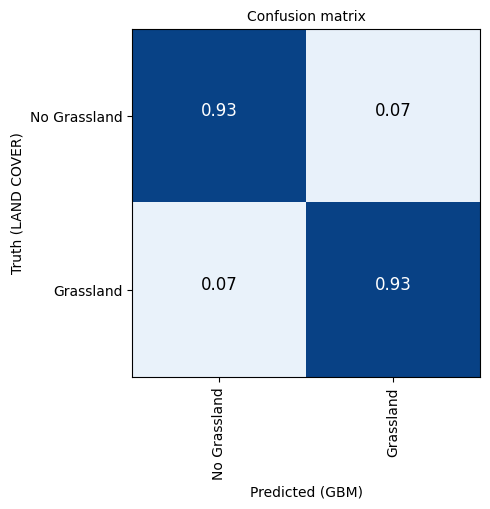

In [29]:
fig = plt.figure(figsize=(5, 5))

confusion_matrix_gbm = metrics.confusion_matrix(true_labels, predictions)
plot_confusion_matrix(
    confusion_matrix_gbm,
    classes=[label_map[str(idx)] for idx in class_labels],
    normalize=True,
    ylabel="Truth (LAND COVER)",
    xlabel="Predicted (GBM)",
    title="Confusion matrix",
)

plt.show()

Another important aspect especially when further developing the model is the importance of different parameters. These parameters are shown here.

In [30]:
# Feature names
def plot_feature_importances(model, feature_names):
    feature_importance = model.feature_importances_
    sorted_idx = feature_importance.argsort()

    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.xlabel('Feature importance')
    plt.show()

In [31]:
model.feature_importances_

array([1322, 3489, 2179, 2028, 2571, 3829,  867, 2208,  897, 2586, 3035,
       1984, 1575, 1330], dtype=int32)

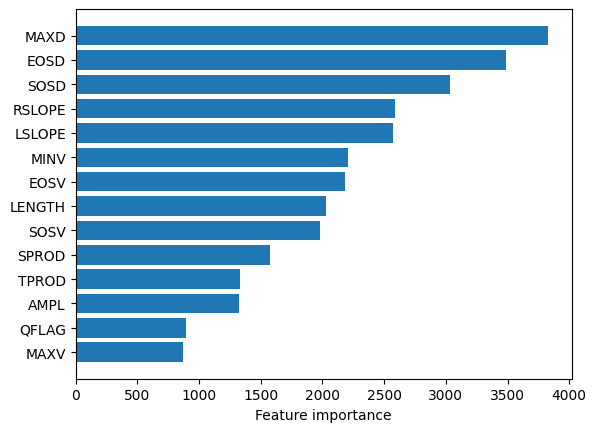

In [32]:
plot_feature_importances(model, ["AMPL","EOSD","EOSV","LENGTH","LSLOPE","MAXD","MAXV","MINV","QFLAG","RSLOPE","SOSD","SOSV","SPROD","TPROD"])

#### Inference

Here we are now using the trained and validated model to classify data for all 4 years for which we downloaded data. This will give us a visual baseline on how well the model performs and how useful it could be for our usecase.

This inference is again done with eo-learn, since a lot of data has to be handled and all of that data is already available in the EOPatches we have constructed earlier.

![Inference](images/inference.svg)

In [33]:
class PredictPatchTask(EOTask):
    """
    Task to make model predictions on a patch. Provide the model and the feature,
    and the output names of labels and scores (optional)
    """

    def __init__(self, model, features_feature, predicted_labels_name, predicted_scores_name=None, scaler=None, dim=None):
        self.model = model
        self.features_feature = features_feature
        self.predicted_labels_name = predicted_labels_name
        self.predicted_scores_name = predicted_scores_name
        self.scaler = scaler
        self.dim = dim

    def execute(self, eopatch):
        for i, name in enumerate(self.predicted_labels_name):
            features = np.expand_dims(eopatch[self.features_feature][i], axis=0)

            t, w, h, f = features.shape
            features = np.moveaxis(features, 0, 2).reshape(w * h, t * f)
            features = scaler.transform(features)

            predicted_labels = self.model.predict(features)
            predicted_labels = predicted_labels.reshape(w, h)
            predicted_labels = predicted_labels[..., np.newaxis]
            eopatch[(FeatureType.MASK_TIMELESS, name)] = predicted_labels

            if i == self.dim:
                predicted_scores = self.model.predict_proba(features)
                _, d = predicted_scores.shape
                predicted_scores = predicted_scores.reshape(w, h, d)
                eopatch[(FeatureType.DATA_TIMELESS, self.predicted_scores_name)] = predicted_scores

        return eopatch


In [34]:
# here set the dim to get the prediction of the year... depends on the years requested the first is 0

# LOAD EXISTING EOPATCHES
load = LoadTask(EOPATCH_SAMPLES_FOLDER)

# PREDICT
predictions = ["LBL_GBM_0","LBL_GBM_1", "LBL_GBM_2", "LBL_GBM_3",  "LBL_GBM_4"]

predict = PredictPatchTask(model, (FeatureType.DATA, "BANDS"), predictions , "SCR_GBM_1", dim=1)

# SAVE
save = SaveTask(EOPATCH_SAMPLES_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

# EXPORT TIFF
#tiff_location = os.path.join(RESULTS_FOLDER, "predicted_tiff_1")
#os.makedirs(tiff_location, exist_ok=True)
#export_tiff = ExportToTiffTask((FeatureType.MASK_TIMELESS, predictions), tiff_location)

workflow_nodes = linearly_connect_tasks(load, predict, save)
workflow = EOWorkflow(workflow_nodes)

In [35]:
# Create a list of execution arguments for each patch
execution_args = []
for i in range(len(patchIDs)):
    execution_args.append(
        {
            workflow_nodes[0]: {"eopatch_folder": f"eopatch_{i}"},
            workflow_nodes[2]: {"eopatch_folder": f"eopatch_{i}"},
        }
    )

# Run the executor
executor = EOExecutor(workflow, execution_args)
executor.run(workers=1, multiprocess=False)
#executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )

  0%|          | 0/20 [00:00<?, ?it/s]

In [36]:
from matplotlib.colors import from_levels_and_colors
lulc_cmap, lulc_norm = from_levels_and_colors([0, 1],['brown','green'], extend="max")

In [37]:
# Draw the Reference map
def plot_predicted_vs_ground_truth():
    idx = np.random.choice(test_ID)
    inspect_size = 100

    eopatch = EOPatch.load(os.path.join(EOPATCH_SAMPLES_FOLDER, f"eopatch_{idx}"), lazy_loading=True)

    w, h = eopatch.mask_timeless["LABEL"].squeeze().shape

    w_min = np.random.choice(range(w - inspect_size))
    w_max = w_min + inspect_size
    h_min = np.random.choice(range(h - inspect_size))
    h_max = h_min + inspect_size


    ground_truth = np.where(np.isin(eopatch.mask_timeless["LABEL"].squeeze()[w_min:w_max, h_min:h_max], to_classify), 1, 0)

    predict = eopatch.mask_timeless["LBL_GBM_3"].squeeze()[w_min:w_max, h_min:h_max]
    diff = ground_truth - predict


    # Create a colormap with white for 0, gray for -1, and black for 1
    cmap_diff = plt.get_cmap('binary', 3)
    cmap_diff.set_bad(color='gray')

    # Create a new figure with 4 subplots
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(22, 5), gridspec_kw={'width_ratios': [1, 1, 1, 1]})

    # Plot the predicted array in the first subplot
    axes[0].imshow(predict, cmap=lulc_cmap, norm=lulc_norm, interpolation='nearest', aspect='auto')
    axes[0].set_title('Predicted')

    # Plot the ground truth array in the second subplot
    axes[1].imshow(ground_truth, cmap=lulc_cmap, norm=lulc_norm, interpolation='nearest', aspect='auto')
    axes[1].set_title('Ground truth')

    # Plot the difference array in the third subplot
    axes[2].imshow(diff, cmap=cmap_diff, interpolation='nearest', aspect='auto')
    axes[2].set_title('Difference')
    # Extract the true color image
    image = eopatch.data['BANDS_TC']
    # Crop to selected region
    # Plot the true color image
    axes[3].imshow(image[0, w_min:w_max, h_min:h_max, :])
    axes[3].set_title('True Color')

    # Show the plot
    plt.show()

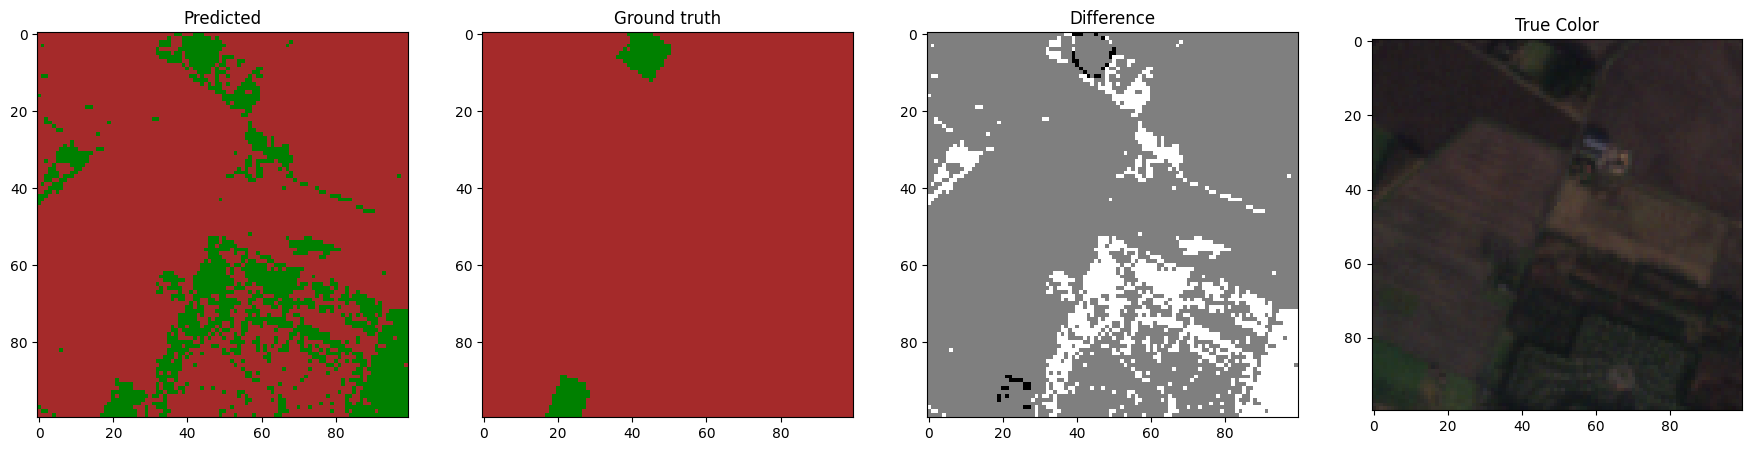

In [38]:
plot_predicted_vs_ground_truth()

In [39]:
def plot_progression():
    idx = np.random.choice(range(number_of_patches))
    inspect_size = 100

    eopatch = EOPatch.load(os.path.join(EOPATCH_SAMPLES_FOLDER, f"eopatch_{idx}"), lazy_loading=True)

    w, h = eopatch.mask_timeless["LABEL"].squeeze().shape

    w_min = np.random.choice(range(w - inspect_size))
    w_max = w_min + inspect_size
    h_min = np.random.choice(range(h - inspect_size))
    h_max = h_min + inspect_size


    ground_truth = np.where(np.isin(eopatch.mask_timeless["LABEL"].squeeze()[w_min:w_max, h_min:h_max], to_classify), 1, 0)

    predict_0 = eopatch.mask_timeless["LBL_GBM_0"].squeeze()[w_min:w_max, h_min:h_max]
    predict_1 = eopatch.mask_timeless["LBL_GBM_1"].squeeze()[w_min:w_max, h_min:h_max]
    predict_2 = eopatch.mask_timeless["LBL_GBM_2"].squeeze()[w_min:w_max, h_min:h_max]
    predict_3 = eopatch.mask_timeless["LBL_GBM_3"].squeeze()[w_min:w_max, h_min:h_max]



    # Create a new figure with 4 subplots
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 10), gridspec_kw={'width_ratios': [1, 1, 1, 1]})

    # Plot the predicted array in the first subplot
    axes[0, 0].imshow(predict_0, cmap=lulc_cmap, norm=lulc_norm, interpolation='nearest', aspect='auto')
    axes[0, 0].set_title('Prediction 2017')

    # Plot the ground truth array in the second subplot
    axes[0, 1].imshow(predict_1, cmap=lulc_cmap, norm=lulc_norm, interpolation='nearest', aspect='auto')
    axes[0, 1].set_title('predicted 2018')

    # Plot the ground truth array in the second subplot
    axes[0, 2].imshow(predict_2, cmap=lulc_cmap, norm=lulc_norm, interpolation='nearest', aspect='auto')
    axes[0, 2].set_title('predicted 2019')

    # Plot the difference array in the third subplot
    axes[0, 3].imshow(predict_3, cmap=lulc_cmap, norm=lulc_norm, interpolation='nearest', aspect='auto')
    axes[0, 3].set_title('predicted 2020')
    # Extract the true color image
    image = eopatch.data['BANDS_TC']
    # Crop to selected region
    # Plot the true color image
    axes[1, 0].imshow(image[0, w_min:w_max, h_min:h_max, :], aspect='auto')
    axes[1, 0].set_title('True Color 2017')

    axes[1, 1].imshow(image[1, w_min:w_max, h_min:h_max, :], aspect='auto')
    axes[1, 1].set_title('True Color 2018')

    axes[1, 2].imshow(image[2, w_min:w_max, h_min:h_max, :], aspect='auto')
    axes[1, 2].set_title('True Color 2019')

    axes[1, 3].imshow(image[3, w_min:w_max, h_min:h_max, :], aspect='auto')
    axes[1, 3].set_title('True Color 2020')

    # Show the plot


    plt.show()

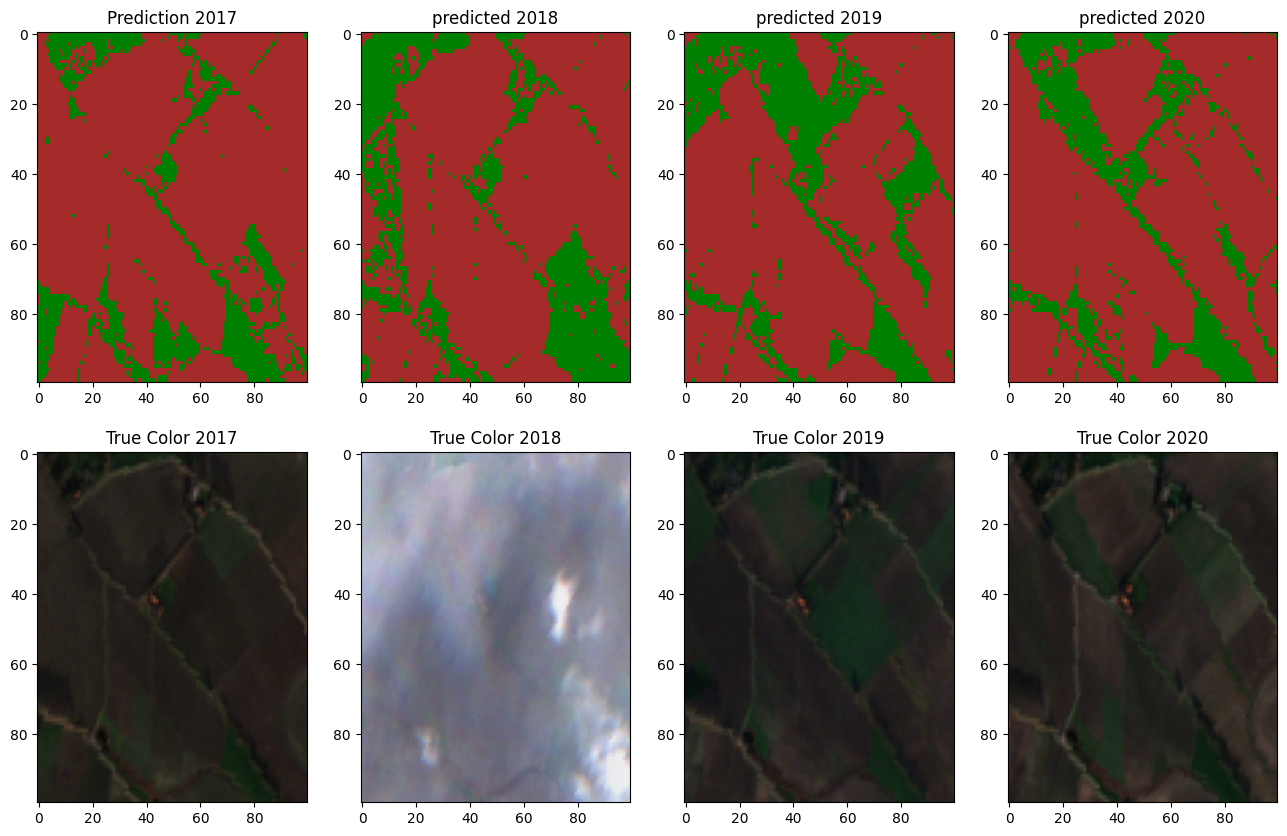

In [40]:
plot_progression()

Since the focus here is showing data preparation and data handling for machine learning tasks, a more thorough analysis will not be carried out. However the notebooks will be made available, so interested people can take a closer look at the data.


## Summary

- Data preparation is essential, bad data will lead to bad results
- Used tools and workflows depend on the scope
- `eo-learn` is well suited for handling large amounts of EO data
- This analysis achieved good results, which could be used to monitor grasslands with some further work